# Notebook 6.3: MPC with Physics-Informed Neural Network (PINN) Models (PINN-MPC)

In Notebook 6.2, we explored using standard Artificial Neural Networks (ANNs) for modeling system dynamics within an MPC framework. While ANNs are powerful function approximators, they learn solely from data and have no inherent understanding of the underlying physical laws governing the system. This can lead to physically implausible predictions, poor extrapolation, and a need for large datasets.

**Physics-Informed Neural Networks (PINNs)** offer a compelling hybrid approach. They integrate known physical laws (typically expressed as Ordinary or Partial Differential Equations - ODEs/PDEs) directly into the neural network's training process. The network is trained to satisfy both the observed data *and* the governing equations.

**Goals of this Notebook:**
1.  Understand the core concept of PINNs.
2.  Select a simple dynamic system with known ODEs.
3.  Formulate the composite PINN loss function ($L_{data} + w_{physics}L_{physics} + w_{BC/IC}L_{BC/IC}$).
4.  Implement and train a PINN using **PyTorch** to learn the system's solution trajectory (and potentially unknown parameters within the ODEs).
5.  Validate the trained PINN model's adherence to physics and data.
6.  Discuss how a trained PINN, representing system dynamics, can be integrated into an NMPC framework (conceptually or with a simplified example).
7.  Highlight the advantages (e.g., data efficiency, physical consistency) and challenges of PINN-MPC.

## 1. Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.integrate import solve_ivp # For generating reference solutions
import casadi as ca # For conceptual MPC integration

# Optional: for nicer plots
plt.rcParams.update({'font.size': 12, 'figure.figsize': (10, 6)})

## 2. The Dynamic System: A Damped Oscillator

Let's choose a simple, well-understood system: a damped linear oscillator. Its dynamics are described by a second-order ODE:
$$ m \frac{d^2x}{dt^2} + c \frac{dx}{dt} + kx = F(t) $$
Where $x$ is position, $m$ is mass, $c$ is damping coefficient, $k$ is spring constant, and $F(t)$ is an external force.

We can rewrite this as a system of two first-order ODEs. Let $x_1 = x$ and $x_2 = \frac{dx}{dt}$ (velocity).
$$ \frac{dx_1}{dt} = x_2 $$
$$ \frac{dx_2}{dt} = \frac{1}{m} (F(t) - c x_2 - k x_1) $$

For this PINN example, our neural network $\mathcal{N}(t; \theta)$ will aim to approximate $x_1(t)$ (and implicitly $x_2(t)$ via its derivative). We might also try to learn one of the parameters, say $c$ or $k$, if it were unknown.

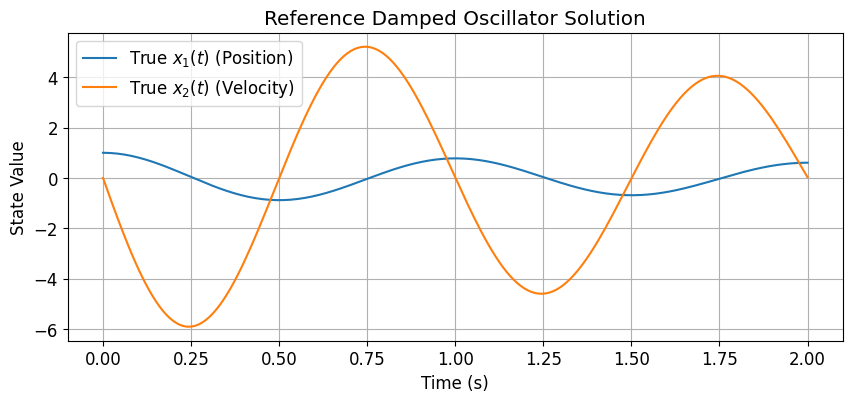

In [2]:
# System Parameters (True values for generating data/reference)
m_true_osc = 1.0
k_true_osc = 4.0 * (np.pi**2) # k for a natural frequency of 2 Hz (period 0.5s) if c=0
c_true_osc = 0.5 # Damping coefficient
F_ext_func = lambda t: 0.0 # No external force for this example (free oscillation)

# ODE function for scipy solver (reference solution)
def damped_oscillator_ode(t, y_state, m, k, c, F_func):
    x1, x2 = y_state # x1 = position, x2 = velocity
    dx1_dt = x2
    dx2_dt = (F_func(t) - c * x2 - k * x1) / m
    return [dx1_dt, dx2_dt]

# Time domain for simulation and PINN training
t_start_osc = 0.0
t_end_osc = 2.0
num_t_points_ref = 200
t_eval_ref = np.linspace(t_start_osc, t_end_osc, num_t_points_ref)

# Initial conditions
x1_0 = 1.0 # Initial position
x2_0 = 0.0 # Initial velocity
y0_osc = [x1_0, x2_0]

# Generate reference solution using scipy ODE solver
sol_ref = solve_ivp(damped_oscillator_ode, [t_start_osc, t_end_osc], y0_osc, 
                    args=(m_true_osc, k_true_osc, c_true_osc, F_ext_func),
                    dense_output=True, t_eval=t_eval_ref)
x1_ref = sol_ref.y[0,:]
x2_ref = sol_ref.y[1,:]

plt.figure(figsize=(10,4))
plt.plot(t_eval_ref, x1_ref, label='True $x_1(t)$ (Position)')
plt.plot(t_eval_ref, x2_ref, label='True $x_2(t)$ (Velocity)')
plt.xlabel('Time (s)'); plt.ylabel('State Value'); plt.title('Reference Damped Oscillator Solution')
plt.legend(); plt.grid(True); plt.show()

## 3. PINN Formulation

**Neural Network $\mathcal{N}(t; \theta)$:** This NN will take time $t$ as input and output the predicted position $\hat{x}_1(t)$. The velocity $\hat{x}_2(t)$ can be obtained by $\frac{d\hat{x}_1}{dt}$ using automatic differentiation.

**Loss Function Components:**
1.  **$L_{data}$ (Data Mismatch Loss):** If we have some (noisy) measurements of $x_1(t)$ at specific time points $t_i^{data}$.
    $L_{data} = \frac{1}{N_{data}} \sum_{i=1}^{N_{data}} (\mathcal{N}(t_i^{data}; \theta) - x_{1,data}^{(i)})^2$
2.  **$L_{physics}$ (ODE Residual Loss):** Enforces the governing ODEs. The residual for the second ODE is:
    $r_{ODE}(t) = m \frac{d^2\mathcal{N}}{dt^2} + c \frac{d\mathcal{N}}{dt} + k \mathcal{N} - F(t)$
    $L_{physics} = \frac{1}{N_{colloc}} \sum_{j=1}^{N_{colloc}} (r_{ODE}(t_j^{colloc}))^2$
    This is evaluated at a set of collocation points $t_j^{colloc}$ distributed across the time domain. The derivatives $\frac{d\mathcal{N}}{dt}$ and $\frac{d^2\mathcal{N}}{dt^2}$ are computed using PyTorch's autograd.
3.  **$L_{IC}$ (Initial Condition Loss):** Enforces the known initial conditions.
    $L_{IC} = (\mathcal{N}(t_0; \theta) - x_{1,0})^2 + (\frac{d\mathcal{N}}{dt}|_{t_0} - x_{2,0})^2$

**Total Loss:** $L = w_{data} L_{data} + w_{physics} L_{physics} + w_{IC} L_{IC}$

In [3]:
# PINN Neural Network Definition
class OscillatorPINN(nn.Module):
    def __init__(self, hidden_sizes=[32, 32]):
        super(OscillatorPINN, self).__init__()
        layers = [nn.Linear(1, hidden_sizes[0]), nn.Tanh()] # Input is time (1D)
        for i in range(len(hidden_sizes) - 1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(hidden_sizes[-1], 1)) # Output is x1 (position, 1D)
        self.net = nn.Sequential(*layers)

        # For learning parameters (optional)
        # self.log_c = nn.Parameter(torch.tensor([np.log(c_true_osc*0.8)], dtype=torch.float32)) # Learn c
        # self.log_k = nn.Parameter(torch.tensor([np.log(k_true_osc*1.2)], dtype=torch.float32)) # Learn k

    def forward(self, t):
        # t should be a column vector with requires_grad=True for derivative calculations
        return self.net(t)

# Instantiate PINN
pinn_model = OscillatorPINN(hidden_sizes=[64, 64, 64])

# Define system parameters (can be made learnable if desired)
m_pinn = torch.tensor([m_true_osc], dtype=torch.float32, requires_grad=False)
k_pinn = torch.tensor([k_true_osc], dtype=torch.float32, requires_grad=False) 
c_pinn = torch.tensor([c_true_osc], dtype=torch.float32, requires_grad=False)
# To learn c and k, use pinn_model.log_c and pinn_model.log_k, then c = torch.exp(self.log_c), etc.

def compute_oscillator_ode_residual(pinn, t_batch, m, k, c, F_func):
    t_batch.requires_grad_(True)
    x1_pred = pinn(t_batch)
    
    # First derivative dx1/dt (velocity x2)
    dx1_dt = torch.autograd.grad(x1_pred, t_batch, 
                                  grad_outputs=torch.ones_like(x1_pred), 
                                  create_graph=True)[0]
    # Second derivative d^2x1/dt^2 (acceleration)
    d2x1_dt2 = torch.autograd.grad(dx1_dt, t_batch, 
                                   grad_outputs=torch.ones_like(dx1_dt), 
                                   create_graph=True)[0]
    
    F_t_batch = torch.tensor([F_func(ti.item()) for ti in t_batch], dtype=torch.float32).reshape_as(x1_pred)
    
    # ODE residual: m*x1_tt + c*x1_t + k*x1 - F = 0
    residual = m * d2x1_dt2 + c * dx1_dt + k * x1_pred - F_t_batch
    return residual, x1_pred, dx1_dt # also return x1, x2 for IC loss

print("PINN model and residual function defined.")

PINN model and residual function defined.


## 4. Training the PINN

Starting PINN training...
Epoch [200/2000], Total Loss: 4.5506e+01, Data: 1.83e-01, Physics: 1.67e+01, IC: 1.05e-01
Epoch [400/2000], Total Loss: 1.7436e+01, Data: 6.45e-02, Physics: 9.70e+00, IC: 1.29e-02
Epoch [600/2000], Total Loss: 1.1855e+01, Data: 2.74e-02, Physics: 8.74e+00, IC: 3.83e-03
Epoch [800/2000], Total Loss: 1.0956e+01, Data: 2.37e-02, Physics: 8.28e+00, IC: 3.11e-03
Epoch [1000/2000], Total Loss: 1.0071e+01, Data: 2.08e-02, Physics: 7.73e+00, IC: 2.61e-03
Epoch [1200/2000], Total Loss: 9.2145e+00, Data: 1.83e-02, Physics: 7.16e+00, IC: 2.28e-03
Epoch [1400/2000], Total Loss: 7.8418e+00, Data: 1.45e-02, Physics: 6.20e+00, IC: 1.84e-03
Epoch [1600/2000], Total Loss: 4.4919e+00, Data: 7.34e-03, Physics: 3.66e+00, IC: 1.01e-03
Epoch [1800/2000], Total Loss: 1.0625e+00, Data: 1.22e-03, Physics: 9.23e-01, IC: 1.68e-04
Epoch [2000/2000], Total Loss: 2.3850e-01, Data: 1.11e-04, Physics: 2.26e-01, IC: 1.81e-05
PINN training complete.


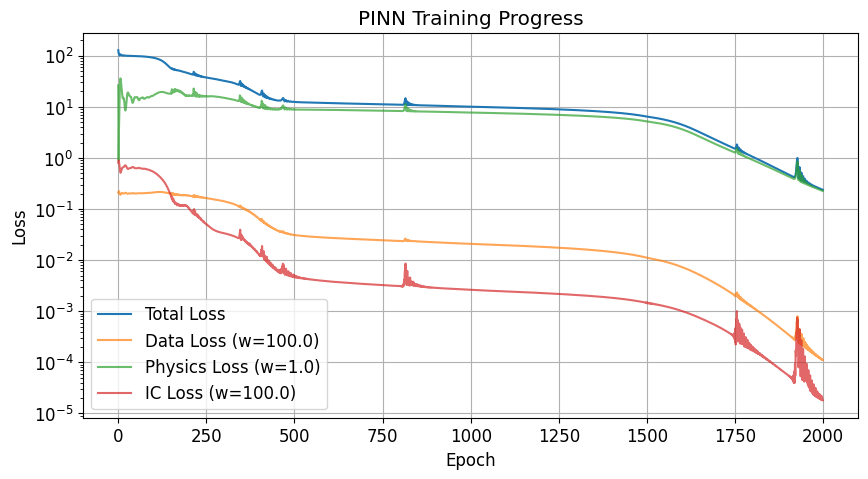

In [4]:
optimizer_pinn = optim.Adam(pinn_model.parameters(), lr=1e-3)
scheduler_pinn = optim.lr_scheduler.StepLR(optimizer_pinn, step_size=500, gamma=0.7)

# Training Data Points (sparse subset of reference for L_data)
num_data_pts_pinn = 20
idx_data = np.random.choice(num_t_points_ref, num_data_pts_pinn, replace=False)
t_data_pinn = torch.tensor(t_eval_ref[idx_data], dtype=torch.float32).reshape(-1,1)
x1_data_pinn = torch.tensor(x1_ref[idx_data], dtype=torch.float32).reshape(-1,1)

# Collocation Points for L_physics (more dense than data points)
num_colloc_pts_pinn = 200
t_colloc_pinn = torch.linspace(t_start_osc, t_end_osc, num_colloc_pts_pinn, 
                               dtype=torch.float32).reshape(-1,1)

# Initial condition time point
t_ic_pinn = torch.tensor([[t_start_osc]], dtype=torch.float32)

# Loss weights
w_data = 100.0
w_physics = 1.0
w_ic = 100.0

epochs_pinn = 2000 # More epochs often needed for PINNs
losses_pinn = {'total': [], 'data': [], 'physics': [], 'ic': []}

print("Starting PINN training...")
for epoch in range(epochs_pinn):
    pinn_model.train()
    optimizer_pinn.zero_grad()
    
    # Data loss
    x1_pred_data = pinn_model(t_data_pinn)
    loss_data = torch.mean((x1_pred_data - x1_data_pinn)**2)
    
    # Physics loss (ODE residual)
    ode_res, _, _ = compute_oscillator_ode_residual(pinn_model, t_colloc_pinn, m_pinn, k_pinn, c_pinn, F_ext_func)
    loss_physics = torch.mean(ode_res**2)
    
    # Initial condition loss
    _, x1_pred_ic, x2_pred_ic = compute_oscillator_ode_residual(pinn_model, t_ic_pinn, m_pinn, k_pinn, c_pinn, F_ext_func)
    loss_ic_x1 = (x1_pred_ic - x1_0)**2
    loss_ic_x2 = (x2_pred_ic - x2_0)**2
    loss_ic = torch.mean(loss_ic_x1 + loss_ic_x2)
    
    total_loss = w_data * loss_data + w_physics * loss_physics + w_ic * loss_ic
    
    total_loss.backward()
    optimizer_pinn.step()
    scheduler_pinn.step()
    
    losses_pinn['total'].append(total_loss.item())
    losses_pinn['data'].append(loss_data.item())
    losses_pinn['physics'].append(loss_physics.item())
    losses_pinn['ic'].append(loss_ic.item())
    
    if (epoch + 1) % 200 == 0:
        print(f"Epoch [{epoch+1}/{epochs_pinn}], Total Loss: {total_loss.item():.4e}, "
              f"Data: {loss_data.item():.2e}, Physics: {loss_physics.item():.2e}, IC: {loss_ic.item():.2e}")

print("PINN training complete.")

# Plot PINN training losses
plt.figure(figsize=(10,5))
plt.plot(losses_pinn['total'], label='Total Loss')
plt.plot(losses_pinn['data'], label=f'Data Loss (w={w_data})', alpha=0.7)
plt.plot(losses_pinn['physics'], label=f'Physics Loss (w={w_physics})', alpha=0.7)
plt.plot(losses_pinn['ic'], label=f'IC Loss (w={w_ic})', alpha=0.7)
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.yscale('log')
plt.title('PINN Training Progress'); plt.legend(); plt.grid(True); plt.show()

## 5. Validating the Trained PINN Model

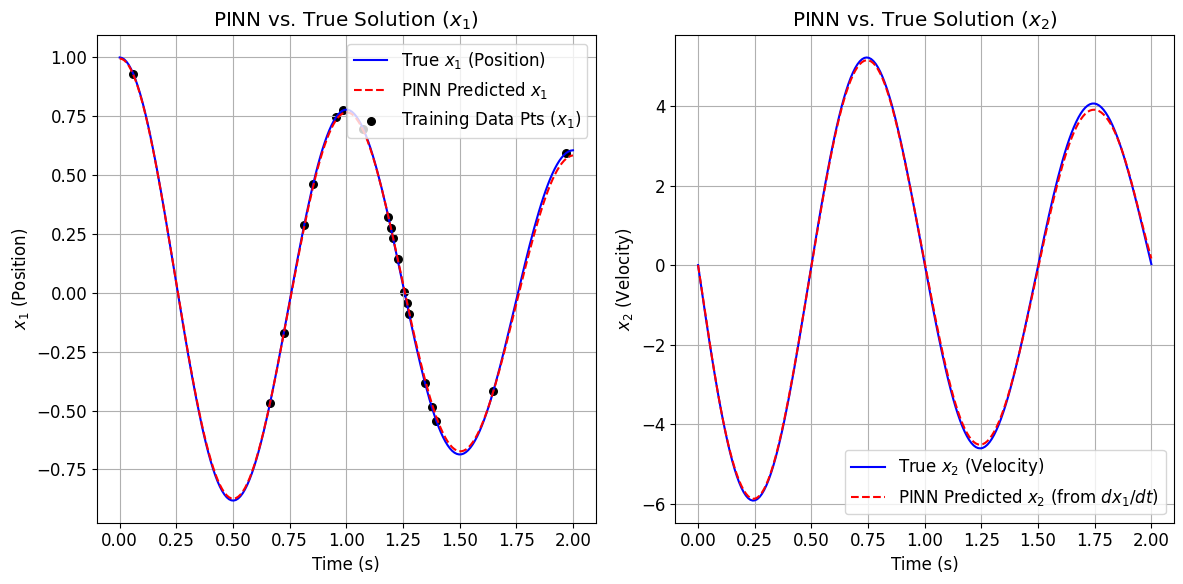

Mean squared ODE residual on test collocation points: 2.6755e-01


In [5]:
pinn_model.eval()
t_dense_test = torch.linspace(t_start_osc, t_end_osc, 200, dtype=torch.float32).reshape(-1,1)
with torch.no_grad():
    x1_pinn_pred_test = pinn_model(t_dense_test).numpy()

# For x2, we need gradients, so re-enable grad for this part
t_dense_test_grad = t_dense_test.clone().requires_grad_(True)
x1_pinn_grad_intermediate = pinn_model(t_dense_test_grad)
x2_pinn_pred_test = torch.autograd.grad(x1_pinn_grad_intermediate, t_dense_test_grad, 
                                         grad_outputs=torch.ones_like(x1_pinn_grad_intermediate), 
                                         create_graph=False)[0].detach().numpy()

plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.plot(t_eval_ref, x1_ref, 'b-', label='True $x_1$ (Position)')
plt.plot(t_dense_test.numpy(), x1_pinn_pred_test, 'r--', label='PINN Predicted $x_1$')
plt.scatter(t_data_pinn.numpy(), x1_data_pinn.numpy(), color='k', s=30, label='Training Data Pts ($x_1$)')
plt.xlabel('Time (s)'); plt.ylabel('$x_1$ (Position)'); plt.title('PINN vs. True Solution ($x_1$)')
plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(t_eval_ref, x2_ref, 'b-', label='True $x_2$ (Velocity)')
plt.plot(t_dense_test.numpy(), x2_pinn_pred_test, 'r--', label='PINN Predicted $x_2$ (from $dx_1/dt$)')
plt.xlabel('Time (s)'); plt.ylabel('$x_2$ (Velocity)'); plt.title('PINN vs. True Solution ($x_2$)')
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()

# Check ODE residual with trained PINN
t_colloc_check = torch.linspace(t_start_osc, t_end_osc, 100, dtype=torch.float32).reshape(-1,1)
ode_res_check, _, _ = compute_oscillator_ode_residual(pinn_model, t_colloc_check, m_pinn, k_pinn, c_pinn, F_ext_func)
print(f"Mean squared ODE residual on test collocation points: {torch.mean(ode_res_check**2).item():.4e}")

## 6. Conceptual Integration of PINN into MPC

Once a PINN is trained to represent the system dynamics $x_{k+1} = f_{PINN}(x_k, u_k, \Delta t)$ or $\dot{x} = f_{PINN}(x,u)$, it can, in principle, replace the model in an NMPC formulation.

**If PINN learns $x(t)$ directly (like $\mathcal{N}(t)$ in our example):**
The PINN itself gives $\hat{x}_1(t_0+j \cdot T_{s,mpc})$. Its derivatives give other states. This can be used for prediction. For control inputs $u_k$ that are piecewise constant, the ODE for PINN training would be $m \ddot{x}_1 + c \dot{x}_1 + k x_1 = u_k$. The PINN $\mathcal{N}(t, u_k; \theta)$ would predict $x_1(t)$ for a given $u_k$ over an interval.

**If PINN learns $f_{discrete}(x_k, u_k)$ or $f_{continuous}(x,u)$:**
This is more direct for MPC. The PINN acts as the $f(\cdot)$ in $x_{k+1}=f(x_k, u_k)$.
   1.  The input to this PINN would be $(x_k, u_k)$.
   2.  The output would be $\Delta x_k$ or $x_{k+1}$.
   3.  The physics loss would enforce the difference/differential equation residual.

**Integration with CasADi for PINN-MPC:**
Similar to ANN-MPC (Notebook 6.2), the trained PyTorch PINN model needs to be callable by CasADi, and CasADi needs its gradients.
1.  **Re-implement PINN in CasADi:** If the PINN structure is a standard FNN, its forward pass (and the computation of derivatives for the physics residual if it was part of the output) can be re-implemented using CasADi symbolic variables with the trained PyTorch weights. This gives CasADi full symbolic access.
2.  **ONNX Export/Import:** Export the PyTorch PINN to ONNX, then import into CasADi. This is suitable for more complex network architectures.
3.  **`ca.Function.external`:** For black-box calls, but getting correct gradients for the NLP solver through the external function (which itself uses PyTorch's autograd) can be tricky without specialized interfaces.

**Example NMPC Objective (if PINN provides $x_{k+1} = f_{PINN}(x_k, u_k)$ for the oscillator):**
Minimize $J = \sum (x_{1,pred} - x_{1,sp})^2 + R \cdot u^2$
Subject to dynamics: $x_{k+1,pred} = f_{PINN}(x_{k,pred}, u_k)$ and input constraints.

**Challenges:**
-   **Computational Cost:** Evaluating a PINN (and its derivatives for the physics part, if the PINN itself is the ODE solver) inside an NMPC loop can be expensive.
-   **Gradient Propagation:** Ensuring correct and efficient gradient propagation from the MPC cost/constraints back through the PINN model to the control inputs $\mathbf{U}_k$ is key.
-   **Complexity of PINN Training:** Training PINNs well, especially for systems with inputs $u_k$ that change over the MPC horizon, is an active research area and more involved than standard supervised ANN training.

## 7. Advantages and Discussion

*   **Data Efficiency:** PINNs can often learn from sparser data than pure ANNs because the physics provides strong regularization.
*   **Physical Consistency:** Predictions are more likely to be physically plausible and generalize better, especially for extrapolation where data is scarce but physics holds.
*   **Parameter Identification:** PINNs can simultaneously learn the system's solution and unknown physical parameters within the ODEs/PDEs.
*   **Handling Systems with Known Structure but Unknown Parameters:** Ideal for many engineering systems, including potentially parts of bioreactor models where overall mass balances are known but kinetic parameters are uncertain or need refinement.

PINN-MPC is a rapidly evolving field. While the implementation can be more complex than standard ANN-MPC, the potential benefits in terms of model robustness and data efficiency are significant.

## 8. Key Takeaways

*   PINNs combine data-driven learning with known physical laws (ODEs/PDEs) by including physics-based residuals in the loss function.
*   Automatic differentiation is crucial for computing derivatives needed for the physics residuals and for training.
*   PINNs can lead to more data-efficient, physically consistent, and generalizable models compared to purely data-driven ANNs.
*   Integrating a trained PINN into an NMPC framework requires careful consideration of how the PINN represents the system dynamics and how its gradients are provided to the NLP solver.
*   This approach is promising for systems where some physical knowledge exists but a full first-principles model is difficult to obtain or has significant uncertainties.

In the next notebook (**Notebook 6.4: MPC with Gaussian Process (GP) Models**), we will explore Gaussian Processes, another powerful data-driven modeling technique that excels at uncertainty quantification.